### Bragg reflection


In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# --- 基本参数 ---
resolution = 50  # points/μm
wavelength = 60  # μm
frequency = 1 / wavelength  # 1/μm = THz/300
fwidth = 0.1 * frequency

n1 = 3.5
n2 = 1.0
n_avg = 0.5 * (n1 + n2)
period = wavelength / (2 * n_avg)  # Bragg 条件

num_periods = 20
grating_length = num_periods * period
dpml = 2
sy = 20  # y方向高度
sz = grating_length + 2 * dpml + 4

cell = mp.Vector3(sy, sz)

# --- 材料 ---
high = mp.Medium(index=n1)
low = mp.Medium(index=n2)

# --- 几何结构：周期性光栅在 z 方向中心布置 ---
geometry = []
for i in range(num_periods):
    z0 = -0.5 * grating_length + i * period
    geometry.append(mp.Block(center=mp.Vector3(0, z0 + period / 4),
                             size=mp.Vector3(mp.inf, period / 2),
                             material=high))
    geometry.append(mp.Block(center=mp.Vector3(0, z0 + 3 * period / 4),
                             size=mp.Vector3(mp.inf, period / 2),
                             material=low))

# --- PML ---
pml_layers = [mp.PML(dpml)]

# --- 激发源 ---
sources = [mp.Source(mp.GaussianSource(frequency, fwidth=fwidth),
                     component=mp.Ez,
                     center=mp.Vector3(0, -0.5 * grating_length + 3),
                     size=mp.Vector3(sy, 0))]  # 平面波源

# --- 模拟器 ---
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    boundary_layers=pml_layers,
                    sources=sources,
                    resolution=resolution,
                    dimensions=2)

# --- 监测面 ---
nfreq = 100
refl_fr = mp.FluxRegion(center=mp.Vector3(0, -0.5 * grating_length + 1), size=mp.Vector3(sy, 0))
tran_fr = mp.FluxRegion(center=mp.Vector3(0, 0.5 * grating_length - 1), size=mp.Vector3(sy, 0))
refl = sim.add_flux(frequency, fwidth, nfreq, refl_fr)
tran = sim.add_flux(frequency, fwidth, nfreq, tran_fr)

# --- 模拟运行 ---
sim.run(until=300)

# --- 获取频谱 ---
flux_freqs = mp.get_flux_freqs(refl)
flux_refl = mp.get_fluxes(refl)
flux_tran = mp.get_fluxes(tran)

# --- 绘图 ---
plt.plot(flux_freqs, flux_refl, label="Reflectance")
plt.plot(flux_freqs, flux_tran, label="Transmittance")
plt.xlabel("Frequency (1/μm)")
plt.ylabel("Flux")
plt.title("2D LCGH Bragg Grating Reflectance/Transmittance")
plt.grid(True)
plt.legend()
plt.show()


### Using the aperiodic structure

In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from meep.materials import Au

###---------------------------------------------------------------Basic config-------------------------------------------------------------------###
resolution = 50
sx = 40
sy = 0
sz = 60
cell = mp.Vector3(sx, sy, sz)
frequency = 1e12
observe_range = 0.1

# thickness of different layers（1 μm）
au_thickness = 0.18
ngaas_thickness_1 = 0.08
Active_region_thickness = 0.0113
ngaas_thickness_2 = 0.7
sigaas_thickness = 30

###---------------------------------------------------------------material config-------------------------------------------------------------------###
#  GaAs N = 5e18
# n_GaAs = mp.Medium(epsilon=12.25)
n_GaAs = mp.Medium(
    epsilon=10.9,
    E_susceptibilities=[
        mp.DrudeSusceptibility(frequency=1.62, 
                               gamma=0.033, 
                               sigma=1.0)])

# GaAs N = 5e15 低参杂
# light_GaAs = mp.Medium(epsilon=12.25)
light_GaAs = mp.Medium(
    epsilon=12.25,
    E_susceptibilities=[
        mp.DrudeSusceptibility(frequency=0.0513, 
                               gamma=0.0033, 
                               sigma=1.0)])

# GaAs 1e18
nplus_GaAs = mp.Medium(
    epsilon=10.9,  
    E_susceptibilities=[
        mp.DrudeSusceptibility(
            frequency=0.7252,   # Plasma resonant frequency
            gamma=0.0333,       # damping constant
            sigma=1.0           # conductivity
        )
    ]
)

# AR
Active_region = mp.air

###---------------------------------------------------------------geometry config-------------------------------------------------------------------###
geometry = []
# Substrate
geometry.append(mp.Block(
                    material=nplus_GaAs,
                    size=mp.Vector3(sigaas_thickness,mp.inf,sz),
                    center=mp.Vector3(x = -sx/2 + sigaas_thickness/2)))
geometry.append(mp.Block(
                    material=n_GaAs,
                    size=mp.Vector3(ngaas_thickness_2,mp.inf,sz),
                    center=mp.Vector3(x= -sx/2 + sigaas_thickness + ngaas_thickness_2/2)))

# QCL active region
geometry.append(mp.Block(
                    material=Active_region,
                    size=mp.Vector3(Active_region_thickness,mp.inf,sz),
                    center=mp.Vector3(x= -sx/2 + sigaas_thickness + ngaas_thickness_2 + Active_region_thickness/2)))

# upper layers
x0 = -sx/2 + sigaas_thickness + ngaas_thickness_2 + Active_region_thickness
geometry.append(mp.Block(
                    material = n_GaAs, 
                    size = mp.Vector3(ngaas_thickness_1,mp.inf,sz), 
                    center = mp.Vector3(x = x0 + ngaas_thickness_1/2)))
geometry.append(mp.Block(
                    material = Au,    
                    size = mp.Vector3(au_thickness,mp.inf,sz),    
                    center = mp.Vector3(x = x0 + ngaas_thickness_1 + au_thickness/2)))

###---------------------------------------------------------------grating config-------------------------------------------------------------------###
# grating parameters
Λ = 0.5                  
slot_width = 0.1           
slot_depth = au_thickness
slot_spacing = Λ / 2       
pattern_1 = "|-||-|-||||||-|||||-||||-|||-||-||||-|||||||-||-||-|||-||-|-||-|||-||-|-||||||-||-|-|||-||-|||||-|||-||-|"
pattern_2 = "|-||-|||||-||||||-|||-||||-||-||-|||||||||-||-|-||-||-||-|-|||-||-||-|-||||||-||||||||-||-||||||-||||---|"
pattern = pattern_1 + pattern_2

# 起始 z 位置，居中布置
z_start = -len(pattern) * slot_spacing / 2

# 放置高度（x 方向中心）
x_grating = x0 + ngaas_thickness_1 +  au_thickness/2

# 光栅 geometry 列表
grating_geometry = []
for i, symbol in enumerate(pattern):
    if symbol == "|":
        z_pos = z_start + i * slot_spacing
        grating_geometry.append(mp.Block(material=mp.air,
                                         size=mp.Vector3(slot_depth,mp.inf,slot_width),
                                         center=mp.Vector3(x_grating,0,z_pos)))
    else:
        z_pos = z_start + i * slot_spacing * 0.5

geometry += grating_geometry
###---------------------------------------------------------------source config-------------------------------------------------------------------###
sources = [mp.Source(
    src=mp.ContinuousSource(frequency=frequency),  
    component=mp.Ez,
    center=mp.Vector3(0, 0,-sz/2),               
    size=mp.Vector3(sx,0,0))]

###---------------------------------------------------------------simulation config-------------------------------------------------------------------###
# 先仿真空结构，记录 incident
# sim = mp.Simulation(cell_size=cell,
#                     # boundary_layers=[mp.PML(0.1)],
#                     geometry=[],
#                     sources=sources,
#                     resolution=resolution,
#                     dimensions=2)
# incident_region = mp.FluxRegion(center=mp.Vector3(0,0,0.95*sz),size=mp.Vector3(sx, 0, sz))
# incident_flux = sim.add_flux((1-observe_range)*frequency, (1+observe_range)*frequency, 400, incident_region)

# sim.run(until=200)
# incident_data = mp.get_fluxes(incident_flux)

# # 再仿真实际结构
# sim.reset_meep()
sim = mp.Simulation(
            cell_size=cell,
            resolution=resolution,
            # boundary_layers=[mp.PML(0.1)],
            geometry=geometry,
            sources=sources,
            dimensions=2)

tran_region = mp.FluxRegion(center=mp.Vector3(0,0,-0.5*sz),size=mp.Vector3(sx, 0,0))
tran_flux = sim.add_flux((1-observe_range)*frequency, (1+observe_range)*frequency, 400, tran_region)

sim.plot2D()
sim.run(until=10)

###---------------------------------------------------------------observasion config-------------------------------------------------------------------###

tran_data = mp.get_fluxes(tran_flux)

# refl_flux = sim.add_flux((1-observe_range)*frequency, (1+observe_range)*frequency, 400, refl_fr)
# refl_fr = mp.FluxRegion(center=mp.Vector3(-cell.x/2 + 1),size=mp.Vector3(0, 0, sz))
# refl_data = mp.get_fluxes(refl_flux)
# R = -np.array(refl_data) / np.array(incident_data)

# 画透射谱

freqs = np.linspace((1-observe_range)*frequency, (1+observe_range)*frequency, 400)
# T = np.array(tran_data) / np.array(incident_data)

plt.figure()
# plt.plot(freqs, R, label='Reflectivity')
plt.plot(freqs, np.array(tran_data), label='Transmittivity')
plt.xlabel('Frequency (a.u.)')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)
plt.show()



### the article


In [ ]:

import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
resolution = 100  # 分辨率
N = 177           # 狭缝数量
Lambda = 1.0      # 光栅最小周期
L = N * Lambda    # LCGH 总长度
dpml = 1.0        # PML 厚度
sx = L + 2 * dpml
cell = mp.Vector3(sx, 0, 0)

# 材料定义
background_eps = 12.0
slit_eps = 1.0
default_material = mp.Medium(epsilon=background_eps)

# 构造狭缝结构（简单均匀光栅）
geometry = []
for i in range(N):
    z = -L/2 + (i + 0.5) * Lambda
    geometry.append(mp.Block(
        material=mp.Medium(epsilon=slit_eps),
        size=mp.Vector3(0.2 * Lambda, mp.inf, mp.inf),
        center=mp.Vector3(z, 0, 0)
    ))

# 源设置：高斯包络覆盖宽频带
sources = [mp.Source(mp.GaussianSource(frequency=1.0, fwidth=0.5),
                     component=mp.Ez,
                     center=mp.Vector3(-L/2 + 1.0, 0, 0),
                     size=mp.Vector3(0, 1, 0))]

# 仿真对象
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=[mp.PML(dpml)],
                    geometry=geometry,
                    sources=sources,
                    default_material=default_material,
                    resolution=resolution)

# 添加反射监测面
refl_fr = mp.FluxRegion(center=mp.Vector3(-L/2 + 0.5))
refl = sim.add_flux(0.5, 1.5, 1000, refl_fr)

# 运行仿真
sim.run(until=200)

# 获取反射数据
freqs = mp.get_flux_freqs(refl)
refl_data = mp.get_fluxes(refl)

# 绘图
plt.figure()
plt.plot(freqs, refl_data)
plt.xlabel("Frequency (a.u.)")
plt.ylabel("Reflectivity")
plt.title("LCGH Reflectivity Spectrum")
plt.grid(True)
plt.show()


### holey-wvg-cavity.py


In [ ]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Video

resolution = 20  # pixels/um

eps = 13  # dielectric constant of waveguide
w = 1.2  # width of waveguide
r = 0.36  # radius of holes
d = 1.4  # defect spacing (ordinary spacing = 1)
N = 3  # number of holes on either side of defect

sy = 6  # size of cell in y direction (perpendicular to wvg.)
pad = 2  # padding between last hole and PML edge
dpml = 1  # PML thickness

sx = 2 * (pad + dpml + N) + d - 1  # size of cell in x direction
cell = mp.Vector3(sx, sy, 0)

blk = mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=mp.Medium(epsilon=eps))
geometry = [blk]

for i in range(N):
    geometry.append(mp.Cylinder(r, center=mp.Vector3(d / 2 + i)))
    geometry.append(mp.Cylinder(r, center=mp.Vector3(-(d / 2 + i))))
    
pml_layers = [mp.PML(1.0)]
fcen = 0.25  # pulse center frequency
df = 0.2  # pulse frequency width

src = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ey,
        center=mp.Vector3(-0.5 * sx + dpml),
        size=mp.Vector3(0, w),
    )
]

sym = [mp.Mirror(mp.Y, phase=-1)]

sim = mp.Simulation(
    cell_size=cell,
    geometry=geometry,
    boundary_layers=pml_layers,
    sources=src,
    symmetries=sym,
    resolution=resolution,
)

freg = mp.FluxRegion(
    center=mp.Vector3(0.5 * sx - dpml - 0.5), size=mp.Vector3(0, 2 * w)
)

nfreq = 500  # number of frequencies at which to compute flux

# transmitted flux
trans = sim.add_flux(fcen, df, nfreq, freg)

f = plt.figure(dpi=150)
sim.plot2D(ax=f.gca())
plt.show()

f = plt.figure(dpi=150)
animate = mp.Animate2D(f=f, fields=mp.Hz, realtime=False, normalize=True)

sim.run(
    mp.during_sources(mp.at_every(0.4, animate)),
    until_after_sources=mp.stop_when_fields_decayed(
        50, mp.Ey, mp.Vector3(0.5 * sx - dpml - 0.5), 1e-3
    ),
)
# plt.close()

filename = "media/hole-wvg-cavity.mp4"
try:
    animate.to_mp4(10, "my_sim.mp4")
except Exception as e:
    print("动画导出失败，跳过。错误信息:", e)
# Video("my_sim.mp4")

def sim_cavity(N=3, sy=6):
    sx = 2 * (pad + dpml + N) + d - 1  # size of cell in x direction
    cell = mp.Vector3(sx, sy, 0)
    blk = mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=mp.Medium(epsilon=eps))
    geometry = [blk]

    for i in range(N):
        geometry.append(mp.Cylinder(r, center=mp.Vector3(d / 2 + i)))
        geometry.append(mp.Cylinder(r, center=mp.Vector3(-(d / 2 + i))))

    src = [
        mp.Source(
            mp.GaussianSource(fcen, fwidth=df),
            component=mp.Ey,
            center=mp.Vector3(-0.5 * sx + dpml),
            size=mp.Vector3(0, w),
        )
    ]

    sim = mp.Simulation(
        cell_size=cell,
        geometry=geometry,
        boundary_layers=pml_layers,
        sources=src,
        symmetries=sym,
        resolution=resolution,
    )

    freg = mp.FluxRegion(
        center=mp.Vector3(0.5 * sx - dpml - 0.5), size=mp.Vector3(0, 2 * w)
    )
    nfreq = 500
    trans = sim.add_flux(fcen, df, nfreq, freg)

    sim.run(
        until_after_sources=mp.stop_when_fields_decayed(
            50, mp.Ey, mp.Vector3(0.5 * sx - dpml - 0.5), 1e-3
        )
    )

    freqs = mp.get_flux_freqs(trans)
    psd = mp.get_fluxes(trans)

    return freqs, psd

freqs_wg, psd_wg = sim_cavity(N=0)  # simple waveguide
freqs_cav, psd_cav = sim_cavity()  # cavity

fig = plt.figure(figsize=(11, 6), dpi=100)
ax = fig.add_subplot(111)
plt.plot(freqs_cav, np.array(psd_cav) / np.array(psd_wg), "o-")
plt.grid(True)
plt.xlabel("Frequency")
plt.ylabel("Transmission")

ax2 = fig.add_axes([0.52, 0.6, 0.2, 0.25])
plt.plot(freqs_cav, np.array(psd_cav) / np.array(psd_wg), "o-")
plt.xlim(0.23, 0.24)
plt.ylim(0, 0.8)
plt.grid(True)
plt.show()

### modify the code


     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (-150,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-147.2,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-145.8,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-143,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-140.2,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-138.8,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric c

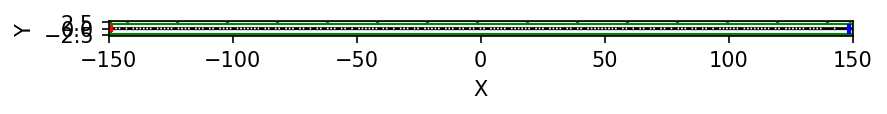

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00196505 s
Working in 2D dimensions.
Computational cell is 300 x 6 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (-150,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-147.2,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-145.8,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-143,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-140.2,0,0)
          rad

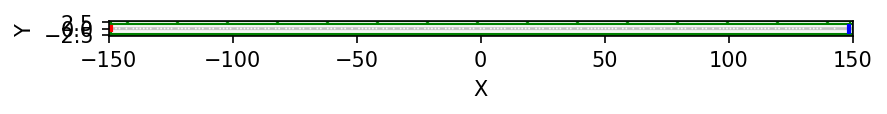

In [6]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Video

resolution = 20  # pixels/um

eps = 13  # dielectric constant of waveguide
w = 1.2  # width of waveguide
r = 0.36  # radius of holes
d = 1.4  # defect spacing (ordinary spacing = 1)
N = 3  # number of holes on either side of defect

sy = 6  # size of cell in y direction (perpendicular to wvg.)
pad = 2  # padding between last hole and PML edge
dpml = 1  # PML thickness

# sx = 2 * (pad + dpml + N) + d - 1  # size of cell in x direction
sx = 300
cell = mp.Vector3(sx, sy, 0)

blk = mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=mp.Medium(epsilon=eps))
geometry = [blk]

pattern_1 = "|-||-|-||||||-|||||-||||-|||-||-||||-|||||||-||-||-|||-||-|-||-|||-||-|-||||||-||-|-|||-||-|||||-|||-||-|"
pattern_2 = "|-||-|||||-||||||-|||-||||-||-||-|||||||||-||-|-||-||-||-|-|||-||-||-|-||||||-||||||||-||-||||||-||||---|"
pattern = pattern_1 + pattern_2

for i, symbol in enumerate(pattern):
    if symbol == "|":
        x_pos = -sx/2 + i * d
        geometry.append(mp.Cylinder(r, center=mp.Vector3(x_pos)))
    else:
        x_pos = -sx/2 + i * d * 0.5

# for i in range(N):
#     geometry.append(mp.Cylinder(r, center=mp.Vector3(d / 2 + i)))
#     geometry.append(mp.Cylinder(r, center=mp.Vector3(-(d / 2 + i))))
    
pml_layers = [mp.PML(1.0)]
fcen = 1e12  # pulse center frequency
df = 0.2  # pulse frequency width

src = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ey,
        center=mp.Vector3(-0.5 * sx + dpml),
        size=mp.Vector3(0, w),
    )
]

sym = [mp.Mirror(mp.Y, phase=-1)]

sim = mp.Simulation(
    cell_size=cell,
    geometry=geometry,
    boundary_layers=pml_layers,
    sources=src,
    symmetries=sym,
    resolution=resolution,
)

freg = mp.FluxRegion(
    center=mp.Vector3(0.5 * sx - dpml - 0.5), size=mp.Vector3(0, 2 * w)
)

nfreq = 500  # number of frequencies at which to compute flux

# transmitted flux
trans = sim.add_flux(fcen, df, nfreq, freg)

f = plt.figure(dpi=150)
sim.plot2D(ax=f.gca())
plt.show()

f = plt.figure(dpi=150)
animate = mp.Animate2D(f=f, fields=mp.Hz, realtime=False, normalize=True)

sim.run(
    mp.during_sources(mp.at_every(0.4, animate)),
    until_after_sources=mp.stop_when_fields_decayed(
        50, mp.Ey, mp.Vector3(0.5 * sx - dpml - 0.5), 1e-3))

try:
    animate.to_mp4(10, "my_sim.mp4")
except Exception as e:
    print("anime output fail, skip, the error information is ", e)
Video("my_sim.mp4")

In [ ]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Video

def sim_cavity(N,sx,sy=6,fcen=10):
    resolution = 20  # pixels/um

    eps = 13  # dielectric constant of waveguide
    w = 1.2  # width of waveguide
    r = 0.36  # radius of holes
    d = 1.4  # defect spacing (ordinary spacing = 1)
    N = N  # number of holes on either side of defect

    pad = 2  # padding between last hole and PML edge
    dpml = 1  # PML thickness

    # sx = 2 * (pad + dpml + N) + d - 1  # size of cell in x direction
    
    cell = mp.Vector3(sx, sy, 0)
    blk = mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=mp.Medium(epsilon=eps))
    geometry = [blk]

    pattern_1 = "|-||-|-||||||-|||||-||||-|||-||-||||-|||||||-||-||-|||-||-|-||-|||-||-|-||||||-||-|-|||-||-|||||-|||-||-|"
    pattern_2 = "|-||-|||||-||||||-|||-||||-||-||-|||||||||-||-|-||-||-||-|-|||-||-||-|-||||||-||||||||-||-||||||-||||---|"
    pattern = pattern_1 + pattern_2

    if N == 0:
        for i in range(N):
            geometry.append(mp.Cylinder(r, center=mp.Vector3(d / 2 + i)))
            geometry.append(mp.Cylinder(r, center=mp.Vector3(-(d / 2 + i))))
    else:
        for i, symbol in enumerate(pattern):
            if symbol == "|":
                x_pos = -sx/2 + i * d
                geometry.append(mp.Cylinder(r, center=mp.Vector3(x_pos)))
            else:
                x_pos = -sx/2 + i * d * 0.5

    pml_layers = [mp.PML(1.0)]
    # fcen = 0.25  # pulse center frequency
    df = 0.2  # pulse frequency width

    src = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
            component=mp.Ey,
            center=mp.Vector3(-0.5 * sx + dpml),
            size=mp.Vector3(0, w))]

    sym = [mp.Mirror(mp.Y, phase=-1)]

    sim = mp.Simulation(
        cell_size=cell,
        geometry=geometry,
        boundary_layers=pml_layers,
        sources=src,
        symmetries=sym,
        resolution=resolution)
    
    freg = mp.FluxRegion(
        center=mp.Vector3(0.5 * sx -dpml - 0.5), size=mp.Vector3(0, 2 * w))

    nfreq = 100  # number of frequencies at which to compute flux

    # transmitted flux
    trans = sim.add_flux(fcen, df, nfreq, freg)
    # sim.plot2D()
    sim.run(until_after_sources=mp.stop_when_fields_decayed(
            50, mp.Ey, mp.Vector3(0.5 * sx - dpml), 1e-3))

    freqs = mp.get_flux_freqs(trans)
    psd = mp.get_fluxes(trans)

    return freqs, psd

sx_main = 50
sy_main = 6
fcen_main = 1e12

freqs_wg, psd_wg = sim_cavity(N=0,sx = sx_main,fcen=fcen_main)  # simple waveguide
freqs_cav, psd_cav = sim_cavity(N=1,sx = sx_main,fcen=fcen_main)  # cavity

fig = plt.figure(figsize=(11, 6), dpi=100)
ax = fig.add_subplot(111)
plt.plot(freqs_cav, np.array(psd_cav) / np.array(psd_wg), "o-")
plt.grid(True)
plt.xlabel("Frequency")
plt.ylabel("Transmission")

# ax2 = fig.add_axes([0.52, 0.6, 0.2, 0.25])
# plt.plot(freqs_cav, np.array(psd_cav) / np.array(psd_wg), "o-")
# plt.xlim(0.23, 0.24)
# plt.ylim(0, 0.8)
# plt.grid(True)
# plt.show()

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00197506 s
Working in 2D dimensions.
Computational cell is 50 x 6 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
time for set_epsilon = 0.0782781 s
-----------
field decay(t = 50.025000000000006): 1.869320177749841e-51 / 1.869320177749841e-51 = 1.0
field decay(t = 100.05000000000001): 1.2008332000672037e-34 / 1.2008332000672037e-34 = 1.0
field decay(t = 150.07500000000002): 3.05843886467309e-35 / 1.2008332000672037e-34 = 0.2546930634914097
field decay(t = 200.10000000000002): 1.4797697776286937e-31 / 1.4797697776286937e-31 = 1.0
